In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir( os.path.join('..', 'notebook_format') )
from formats import load_style
load_style(plot_style = False)

In [2]:
os.chdir(path)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

# create the SparkSession class,
# which is the entry point into all functionality in Spark
spark = (SparkSession
         .builder
         .master('local[7]') # set it to run on 7 cores on local
         .appName('Crime')
         .config(conf = SparkConf())
         .getOrCreate())

# set the log level to ERROR to prevent 
# the terminal from showing too many information
sc = spark.sparkContext
sc.setLogLevel('ERROR')

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,pyspark

Ethen 2017-06-07 11:13:13 

CPython 3.5.2
IPython 5.3.0

numpy 1.12.1
pandas 0.19.2
matplotlib 2.0.0
pyspark 2.1.0+hadoop2.7


# Spark Exercise

Please use the following [link](https://drive.google.com/file/d/0Bz1lG0yegjarWWRoYjI1SWtfUlU/view?usp=sharing) to download the dataset.

## Question 1

By using SparkSQL generate a bar chart of average crime events by month. Find an explanation of results

In [3]:
# have a peek at the data
data_path = 'Crimes_-_2001_to_present.csv'
df = spark.read.csv(data_path, sep = ',', header = True)
df.take(1)

[Row(ID='10078659', Case Number='HY267429', Date='05/19/2015 11:57:00 PM', Block='010XX E 79TH ST', IUCR='143A', Primary Type='WEAPONS VIOLATION', Description='UNLAWFUL POSS OF HANDGUN', Location Description='STREET', Arrest='true', Domestic='false', Beat='0624', District='006', Ward='8', Community Area='44', FBI Code='15', X Coordinate='1184626', Y Coordinate='1852799', Year='2015', Updated On='05/26/2015 12:42:06 PM', Latitude='41.751242944', Longitude='-87.599004724', Location='(41.751242944, -87.599004724)')]

In [4]:
# extract the month and year from the date column
split_col = F.split(df['Date'], ' ')
df = df.withColumn('Day', split_col.getItem(0))
split_col = F.split(df['Day'], '/')
df = df.withColumn('Month', split_col.getItem(0))
df = df.withColumn('Year', split_col.getItem(2))
df.take(1)

[Row(ID='10078659', Case Number='HY267429', Date='05/19/2015 11:57:00 PM', Block='010XX E 79TH ST', IUCR='143A', Primary Type='WEAPONS VIOLATION', Description='UNLAWFUL POSS OF HANDGUN', Location Description='STREET', Arrest='true', Domestic='false', Beat='0624', District='006', Ward='8', Community Area='44', FBI Code='15', X Coordinate='1184626', Y Coordinate='1852799', Year='2015', Updated On='05/26/2015 12:42:06 PM', Latitude='41.751242944', Longitude='-87.599004724', Location='(41.751242944, -87.599004724)', Day='05/19/2015', Month='05')]

In [5]:
# register the DataFrame as a SQL temporary view, so 
# we can directly use SQL query to interact with spark DataFrame
df.createOrReplaceTempView('crime')
sql_query = (
    'SELECT Month, COUNT(*) / COUNT(DISTINCT Year) AS Average '
    'FROM crime '
    'GROUP BY Month '
    'ORDER BY Month'
)
avg_month = spark.sql(sql_query).toPandas()
avg_month.to_csv('avg_month.txt', index = False)
avg_month

,Month,Average
0,01,30899.800000
1,02,27197.133333
2,03,32860.333333
3,04,32948.733333
4,05,34767.266667
5,06,36050.428571
6,07,37949.642857
7,08,37470.857143
8,09,35192.428571
9,10,35715.571429


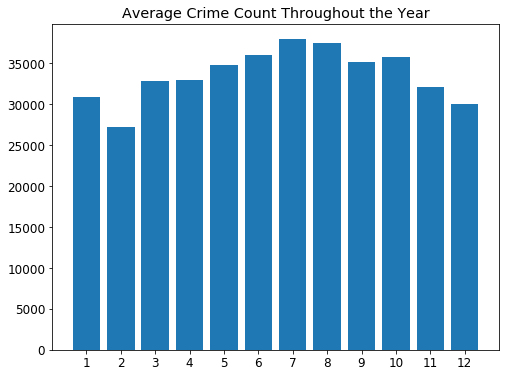

In [6]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

plt.bar(avg_month['Month'].astype('float64'), avg_month['Average'])
plt.title('Average Crime Count Throughout the Year')
plt.xticks(range(1, 13))
plt.show()

Judging from the plot below, we can see that the average crime count tends to be higher during the summer. The reason behind this phenomenon might be:

- The elevated temperature makes people more irritable, which leads to a rise in aggressive behavior and crime.
- During the summer, people tend to leave their windows open more often to cool down or spend more time outside to enjoy outdoor activities. Both of them gives burglars more opportunity to break into people's home.

## Question 2

- Find the top 10 blocks in crime events in the last 3 years
- Find the two beats that are adjacent with the highest correlation in the number of crime events (this will require you looking at the map to determine if the correlated beats are adjacent to each other) over the last 5 years
- Determine if the number of crime events is different between Mayors Daly and Emanuel at a granularity of your choice (not only at the city level). Find an explanation of results. Side information: Rahm Emanuel is the current mayor of Chicago, and Richard Daley was his predecessor (left the office in 2011)

The following section also contains a small example of how to use the `mapPartition` function.

In [7]:
# suppose our task if to find the maximum temperature of the year 1901, 1902
temp = sc.parallelize(['1901,52', '1901,45', '1902,50', '1902,70', '2000,100'])

# since map works with a single record, for each input there has to be an output
# hence we have to write a separate map and filter function to filter out the record
# that does not belong to 1901, 1902
(temp
 .map(lambda x: x.split(','))
 .filter(lambda x: x[0] in {'1901', '1902'})
 .reduceByKey(lambda x, y: max(x, y))
 .collect())

[('1901', '52'), ('1902', '70')]

In [8]:
def filter_year(iterator):
    # loop through each data point in
    # the chunk of data and do whatever
    for line in iterator:
        year, temperature = line.split(',')
        if year in {'1901', '1902'}:
            yield year, temperature

# by using mapPartition we can use a function to work 
# with each partition (i.e. chunk of data), thus we 
# can combine the map and filter logic within each partition
(temp
 .mapPartitions(filter_year)
 .reduceByKey(lambda x, y: max(x, y))
 .collect())

[('1901', '52'), ('1902', '70')]

In [10]:
# extract the year from the date column
data_path = 'Crimes_-_2001_to_present.csv'
df = spark.read.csv(data_path, sep = ',', header = True)

split_col = F.split(df['Date'], ' ')
df = df.withColumn('Day', split_col.getItem(0))
split_col = F.split(df['Day'], '/')
df = df.withColumn('Month', split_col.getItem(0).cast('int'))
df = df.withColumn('Year', split_col.getItem(2).cast('int'))

# obtain the starting year for the notion of last three year
unique_years = (df
                .select(df['Year'])
                .distinct()
                .orderBy('Year')
                .rdd.map(lambda x: x.Year)
                .collect())
n_years = 3
year_threshold = unique_years[-n_years]
year_threshold

2013

In [11]:
# top 10 blocks in terms of crime events
n_top = 10
crime_per_block = (df
                   .filter(df['Year'] >= year_threshold)
                   .groupBy('Block')
                   .count()
                   .orderBy('count', ascending = False)
                   .limit(n_top)
                   .toPandas())
crime_per_block

,Block,count
0,001XX N STATE ST,1745
1,0000X W TERMINAL ST,1340
2,008XX N MICHIGAN AVE,1083
3,076XX S CICERO AVE,1037
4,0000X N STATE ST,794
5,051XX W MADISON ST,661
6,064XX S DR MARTIN LUTHER KING JR DR,628
7,083XX S STEWART AVE,604
8,046XX W NORTH AVE,571
9,009XX W BELMONT AVE,550


For part 1, the top 10 blocks in terms of number of crime events are places either in downtown Chicago or the South part of Chicago. This is probably due to the fact that those areas are densely populated, hence increases the chance of crime occurence.

---

For the problem of finding the two beats that are adjacent with the highest correlation in the number of crime events, I decided to use the [rdd `corr`](https://spark.apache.org/docs/2.1.0/mllib-statistics.html#correlations) function from the mllib package to perform the operation. Even thought there's a [DataFrame `corr`](http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark.sql.DataFrame.corr) function, I couldn't find an easy way to utilize that API.

In [12]:
# compare correlation across years
n_years = 5
year_threshold = unique_years[-n_years]

def filter_year(iterator):
    for beat, year in iterator:
        if year >= year_threshold:
            yield (beat, year), 1

# the sort by key is just to make the output
# cleaner, we don't actually need it
crime_per_group = (df
                   .select(df['Beat'], df['Year'])
                   .rdd.mapPartitions(filter_year)
                   .reduceByKey(lambda x, y: x + y)
                   .sortByKey())
crime_per_group.take(10)

[(('0111', 2011), 1040),
 (('0111', 2012), 1445),
 (('0111', 2013), 1644),
 (('0111', 2014), 1632),
 (('0111', 2015), 530),
 (('0112', 2011), 736),
 (('0112', 2012), 1471),
 (('0112', 2013), 1499),
 (('0112', 2014), 1343),
 (('0112', 2015), 449)]

In [13]:
def beat2key(x):
    (beat, year), count = x
    # choose a random delimiter to separate the
    # two values and the next value that will be
    # concatenated to it
    value = str(year) + ',' + str(count) + ';'
    return beat, value

# combine the count for each beat together
# into one string value
crime_per_beat = (crime_per_group
                  .map(beat2key)
                  .reduceByKey(lambda x, y: x + y))
crime_per_beat.take(3)

[('1613', '2011,517;2012,505;2013,431;2014,470;2015,166;'),
 ('1422', '2011,1535;2012,1465;2013,1249;2014,945;2015,302;'),
 ('1411', '2011,958;2012,936;2013,772;2014,721;2015,214;')]

In [14]:
def get_count_per_year(iterator):
    for beat, value in iterator:
        # filter out the last ';'
        year_and_count = value.split(';')[:-1]
        if len(year_and_count) == n_years:
            year_and_count = [tuple(e.split(',')) for e in year_and_count]
            for year, count in year_and_count:
                value = beat + ',' + count + ';'
                yield year, value

# convert the single string value into numeric value and
# filter out any beat that does not have all the values,
# i.e. does not have records for all the year;
# also convert year as key since the correlation function
# assumes that each column is a record as oppose to each row
count_per_year = (crime_per_beat
                  .mapPartitions(get_count_per_year)
                  .reduceByKey(lambda x, y: x + y))
count_per_year.take(1)

[('2011',
  '1613,517;1422,1535;1411,958;0934,1340;1021,1518;0234,1040;0232,1022;2431,684;0114,18;1522,2559;1531,1798;1922,634;0431,1595;1614,680;0411,1534;0612,2272;2023,645;2011,1027;1733,1132;0631,1942;1831,1630;1222,786;2515,1609;1914,14;0533,1442;0123,1266;0225,8;0935,1221;1933,1050;0222,925;1713,824;2422,1487;1112,2095;0333,1125;2433,1195;1233,851;1813,542;0614,1346;2535,1709;2212,1429;1223,1057;1913,793;0922,948;0824,1760;2412,1232;1113,1599;0911,1335;1915,16;0311,882;1022,1366;1224,917;0914,1571;2211,933;1634,1096;0433,1163;0531,1268;2031,554;1623,1055;2512,1681;1013,1268;0322,1504;0122,1949;1232,409;2012,552;0715,1121;1653,286;1214,5;2522,1219;0622,889;1711,850;1421,1114;1722,1178;1732,1258;0213,737;2513,678;0422,1386;0613,1548;1023,895;0725,1677;2525,922;1431,1011;0511,2594;1433,1365;0512,2071;0214,722;1131,913;1132,1714;0231,310;0814,881;1213,859;0132,2183;0221,505;1133,1689;0825,2499;1612,494;0313,1502;0925,652;1125,473;1414,784;1811,915;1215,2;1211,1470;2013,623;1225,6;081

In [15]:
def get_unique_beats(count_per_year):
    unique_beats = []
    _, value = count_per_year
    beat_and_count = value.split(';')[:-1]
    beat_and_count = [tuple(e.split(',')) for e in beat_and_count]
    beat_and_count = sorted(beat_and_count)
    for beat, _ in beat_and_count:
        unique_beats.append(beat)
    
    return unique_beats


# load all the distinct beat into memory,
# feasible since there's only around 300 of them
unique_beats = get_unique_beats(count_per_year.first())
len(unique_beats)

274

In [16]:
from pyspark.mllib.stat import Statistics

def get_beat_count(x):
    _, value = x
    beat_and_count = value.split(';')[:-1]
    beat_and_count = [tuple(e.split(',')) for e in beat_and_count]
    beat_and_count = sorted(beat_and_count)
    count = [int(count) for _, count in beat_and_count]
    return count      

# fill the diagonal with 0 instead of 1 so they will
# not be considered when retrieving the largest correlation
raw_count = count_per_year.map(get_beat_count)
corr_m = Statistics.corr(raw_count, method = 'pearson')
corr_m.flags['WRITEABLE'] = True
np.fill_diagonal(corr_m, 0.)
corr_m

array([[ 0.        ,  0.95677052,  0.897641  , ...,  0.7133157 ,
         0.71141596,  0.54571851],
       [ 0.95677052,  0.        ,  0.87074554, ...,  0.64021917,
         0.6539807 ,  0.48406046],
       [ 0.897641  ,  0.87074554,  0.        , ...,  0.93041864,
         0.94033636,  0.84316419],
       ..., 
       [ 0.7133157 ,  0.64021917,  0.93041864, ...,  0.        ,
         0.99396707,  0.97564078],
       [ 0.71141596,  0.6539807 ,  0.94033636, ...,  0.99396707,
         0.        ,  0.97296516],
       [ 0.54571851,  0.48406046,  0.84316419, ...,  0.97564078,
         0.97296516,  0.        ]])

In [17]:
# flatten the 2d correlation matrix and
# sort it by decreasing order, then we grab
# the top n elements;
# since correlation matrix is symmetric,
# we take the largest n * 2 and with a stride of 2
n_largest = 100
corr_result = np.ravel(corr_m)
indices = np.argsort(corr_result)[::-1]
largest_indices = indices[:(n_largest * 2):2]

# obtain the corresponding index in the
# original correlation matrix (e.g. element (3, 2)
# contains the largest value thus it comes first)
rows, cols = np.unravel_index(largest_indices, corr_m.shape)
rows, cols

(array([ 41, 242, 162, 264,  80,  44, 122, 208,  51, 247, 252, 187, 159,
        180, 169, 169, 204, 175,  37,  42,  45, 253,  41,  98, 199,  89,
        226,  57, 212, 271, 164,  18,  60,  70, 173, 254,  40,  98, 254,
        158,  65, 264,  42, 242, 262,  33, 133,  60, 205,  70,  99,  53,
        190, 271,  87,  37, 207, 257,  53, 202, 240,  22, 260,  71,  36,
        201,  35, 176, 249, 164,  44,  55,  41,  88, 273,  32, 254,  51,
        267, 125,  56,  37, 128, 258, 264, 229, 164, 244,  88, 235, 232,
        171, 256, 190,  27,  43, 207,  35, 139, 197]),
 array([182, 233,  86, 216, 142,  49,  35,  29,  30,  72, 176, 182, 210,
        128, 215,  36, 201, 246, 105, 167,  88,  73, 187,  48, 233, 216,
        231, 170,  52, 252, 234, 238,  92,  92, 205, 197,  47, 249, 118,
         54,  68,  89, 262, 199, 202, 122, 134,  93,  94,  60, 189,  76,
        179, 182,  27, 128, 124,  66, 125, 200,  87, 216, 256, 142, 215,
        239,  33, 271,  48,  71,  32,  36, 271,  30, 204, 255,  63,  

After computing the year-level crime number correlation between all the pairwise beats combination and outputting the top 100 combination, the two adjacent beats that have the highest correlation is listed below (this is done by manually inspecting the top 100 pairs).

In [18]:
results = []
for i, j in zip(rows, cols):
    result = [unique_beats[i], unique_beats[j], corr_m[i, j]]
    results.append(result)

df_corr = pd.DataFrame(results, columns = ['beat1', 'beat2', 'corr'])
df_corr[ (df_corr['beat1'] == '1121') & (df_corr['beat2'] == '1122') ]

,beat1,beat2,corr
46,1121,1122,0.999749


For part 3, determining if the number of crime events is different between Mayors Daly and Emanuel, we will compute the monthly crime occurences per beat and perform a pair t-test to evaluate whether the difference is significant or not.

In [19]:
df = spark.read.csv(data_path, sep = ',', header = True)
split_col = F.split(df['Date'], ' ')
df = df.withColumn('Day', split_col.getItem(0))
split_col = F.split(df['Day'], '/')
df = df.withColumn('Month', split_col.getItem(0).cast('int'))
df = df.withColumn('Year', split_col.getItem(2).cast('int'))

emanuel = (df
           .filter(df['Year'] > 2011)
           .groupBy('Beat', 'Month')
           .count()
           .withColumnRenamed('count', 'EmanuelCount'))

daley = (df
         .filter(df['Year'] <= 2011)
         .groupBy('Beat', 'Month')
         .count()
         .withColumnRenamed('count', 'DaleyCount'))

joined = (emanuel
          .join(daley, on = ['Beat', 'Month'])
          .withColumn('Diff', (F.col('EmanuelCount') - F.col('DaleyCount')).alias('double')))
joined.show()

+----+-----+------------+----------+-----+
|Beat|Month|EmanuelCount|DaleyCount| Diff|
+----+-----+------------+----------+-----+
|0332|    4|         465|      1672|-1207|
|0412|    4|         478|      1789|-1311|
|0413|    8|         434|      1877|-1443|
|0434|    7|         253|       859| -606|
|0624|    6|         540|      2863|-2323|
|1113|    1|         503|      1518|-1015|
|1331|    8|          91|      1358|-1267|
|1532|    8|         472|      2437|-1965|
|1613|    9|         138|       611| -473|
|1655|    5|          33|        16|   17|
|1814|    7|         326|      1186| -860|
|1834|    8|         582|      2654|-2072|
|2031|    3|         144|       697| -553|
|2211|    7|         240|      1255|-1015|
|2423|   11|         144|      1005| -861|
|2522|    4|         327|      1346|-1019|
|2534|    8|         424|      2220|-1796|
|0123|    2|         339|      1154| -815|
|0212|    7|         312|      1355|-1043|
|0214|    7|         222|       934| -712|
+----+-----

In [20]:
# compute the pair t-test
test_info = (joined
             .select(F.mean(F.col('Diff')).alias('Mean'),
                     F.stddev(F.col('Diff')).alias('Std'),
                     F.count(F.col('Diff')).alias('Count'))
             .rdd.map(lambda x: (x.Mean, x.Std, x.Count))
             .collect())
test_info

[(-1061.9955960070463, 512.3930046068413, 3406)]

In [21]:
# the t value is extremely large,
# indicating that there is a difference in crime
mean, std, count = test_info[0]
standard_error = std / np.sqrt(count)
tvalue = mean / standard_error
tvalue

-120.96001879348958

We observe a large pair t-statistic when comparing monthly crime numbers between mayor Daley and Emanuel. This indicates the data provides strong evidence against the null hypothesis in which there is no difference in the number of crimes between the two mayors. And based on the way the number is calculated, a large negative number means there's significantly less number of crimes when Rahm Emanuel (the current mayor of Chicago) is mayor.

## Question 3

Predict the number of crime events in the next week at the beat level.

- Framed the problem as a supervised machine learning problem, thus lagged features were created. i.e. we use week 1, 2, 3's number to predict the number for week 4. We could have framed it as a time series problem, but here we're simply using it as a chance to familarize ourselves with Spark ML's API
- Trained a RandomForest model for every beat level. This decision is due to the fact that if we were to only train one model, it would require us to one-hot encode around 300 different beat values, which is often times not ideal as a categorical variable with too many distinct levels often leads to overfitting
- For the RandomForest model, 3-fold cross validation and a grid search on the `maxDepth` parameter was performed

---

A quick intro into the SQL window function:

Window functions operate on a set of rows and return a single value for each row from the underlying query. When we use a window function in a query, we define the window using the `OVER()` clause, which has the folloiwing capabilities:

- Defines window partitions to form groups of rows. (PARTITION BY clause)
- Orders rows within a partition. (ORDER BY clause)

e.g.

The following query uses the `AVG()` window function with the `PARTITION BY` clause to determine the average car sales for each dealer in Q1:

```sql
SELECT 
    emp_name, dealer_id, sales, 
    AVG(sales) OVER (PARTITION BY dealer_id) AS avgsales 
FROM 
    q1_sales;
```

<img src="window_query.png" width="40%" height="40%">

For more information, including different types of window function the following link gives a very nice overview. [Drill Documentation: SQL Window Functions Introduction](https://drill.apache.org/docs/sql-window-functions-introduction/)

In [22]:
from pyspark.sql.window import Window

# Reference
# ---------
# https://stackoverflow.com/questions/34295642/spark-add-new-column-to-dataframe-with-value-from-previous-row
d = sc.parallelize([(4, 9.0), (3, 7.0), (2, 3.0), (1, 5.0)]).toDF(['id', 'num'])
d.show()

# here we define a window to create a lagged feature,
# so every row gets shifted up by 1 (determined by the
# count parameter of the lag function); remember to drop
# the na value since there's no record before id1
w = Window().partitionBy().orderBy('id')
d = (d
     .withColumn('new_col', F.lag(F.col('num'), count = -1).over(w))
     .na.drop())
d.show()

+---+---+
| id|num|
+---+---+
|  4|9.0|
|  3|7.0|
|  2|3.0|
|  1|5.0|
+---+---+

+---+---+-------+
| id|num|new_col|
+---+---+-------+
|  1|5.0|    3.0|
|  2|3.0|    7.0|
|  3|7.0|    9.0|
+---+---+-------+



In [23]:
from pyspark.sql.window import Window
from pyspark.sql.types import StringType

data_path = 'Crimes_-_2001_to_present.csv'
df = spark.read.csv(data_path, sep = ',', header = True)

def date2weeknumber(date):
    """
    append a 0 in front of single digit week number,
    this is used when sorting the week number so that
    week 02 will still come before week 10
    """
    if len(date) == 2:
        return date
    else:
        return '0' + date

udf_date2weeknumber = F.udf(date2weeknumber, StringType())

# convert the Date column to spark timestamp format to retrieve the time,
# date formats follow the formats at java.text.SimpleDateFormat
#
# Reference
# ---------
# http://docs.oracle.com/javase/6/docs/api/java/text/SimpleDateFormat.html
# https://stackoverflow.com/questions/25006607/how-to-get-day-of-week-in-sparksql
timestamp_format = 'MM/dd/yyyy'
crime = (df
         .withColumn('DateTime', 
                     F.unix_timestamp(F.col('Date'), timestamp_format).cast('timestamp'))
         .withColumn('WeekOfYear', F.weekofyear(F.col('DateTime')).cast('string'))
         .withColumn('WeekOfYear', udf_date2weeknumber(F.col('WeekOfYear')))
         .withColumn('Year', F.year(F.col('DateTime')).cast('string'))
         .withColumn('Time', F.concat(F.col('Year'), F.col('WeekOfYear'))))
crime.take(1)

[Row(ID='10078659', Case Number='HY267429', Date='05/19/2015 11:57:00 PM', Block='010XX E 79TH ST', IUCR='143A', Primary Type='WEAPONS VIOLATION', Description='UNLAWFUL POSS OF HANDGUN', Location Description='STREET', Arrest='true', Domestic='false', Beat='0624', District='006', Ward='8', Community Area='44', FBI Code='15', X Coordinate='1184626', Y Coordinate='1852799', Year='2015', Updated On='05/26/2015 12:42:06 PM', Latitude='41.751242944', Longitude='-87.599004724', Location='(41.751242944, -87.599004724)', DateTime=datetime.datetime(2015, 5, 19, 0, 0), WeekOfYear='21', Time='201521')]

In [24]:
# 1. don't really need orderBy, it's 
# just to make the output cleaner;
# 2. rename the count column to label to
# make it the label column for the modeling part;
# 3. we will be using the crime count dataframe a lot
# to perform the modeling, thus cache it to store it
# in memory
crime_count = (crime
               .select('Beat', 'Time')
               .groupby('Beat', 'Time')
               .count()
               .withColumnRenamed('count', 'label')
               .orderBy('Beat', 'Time')
               .cache())

crime_count.show()

+----+------+-----+
|Beat|  Time|label|
+----+------+-----+
|0111|200101|   35|
|0111|200102|   36|
|0111|200103|   43|
|0111|200104|   29|
|0111|200105|   23|
|0111|200106|   36|
|0111|200107|   21|
|0111|200108|   26|
|0111|200109|   29|
|0111|200110|   32|
|0111|200111|   36|
|0111|200112|   29|
|0111|200113|   34|
|0111|200114|   33|
|0111|200115|   22|
|0111|200116|   28|
|0111|200117|   44|
|0111|200118|   40|
|0111|200119|   32|
|0111|200120|   33|
+----+------+-----+
only showing top 20 rows



In [25]:
# find all the distinct beat and train the model on each
# beat to generate the prediction for next week
beats = (crime_count
         .select('Beat')
         .distinct()
         .rdd.map(lambda x: x.Beat)
         .collect())

In [26]:
# we will use one of the beat to demonstrate the modeling for now
beat = '1011'
subset = (crime_count
          .filter(F.col('Beat') == beat)
          .drop('Beat'))
subset.show()

+------+-----+
|  Time|label|
+------+-----+
|200101|   33|
|200102|   24|
|200103|   29|
|200104|   22|
|200105|   32|
|200106|   35|
|200107|   32|
|200108|   38|
|200109|   34|
|200110|   40|
|200111|   28|
|200112|   41|
|200113|   29|
|200114|   27|
|200115|   34|
|200116|   34|
|200117|   33|
|200118|   45|
|200119|   36|
|200120|   38|
+------+-----+
only showing top 20 rows



In [27]:
def create_lagged_features(spark_df, window_col, feature_col, n_lags):
    """
    Reference
    ---------
    https://stackoverflow.com/questions/34295642/spark-add-new-column-to-dataframe-with-value-from-previous-row
    """
    w = Window().partitionBy().orderBy(window_col)
    lagged = (subset
              .withColumn('Lag1', F.lag(F.col(feature_col), count = 1).over(w))
              .na.drop())
    
    for lag in range(1, n_lags):
        previous_col = 'Lag' + str(lag)
        current_col = 'Lag' + str(lag + 1)
        lagged = (lagged
                  .withColumn(current_col, F.lag(F.col(previous_col), count = 1).over(w))
                  .na.drop())
    
    # after creating the lag sort the time by descending order
    # so it will be easier to project to the future
    lagged = lagged.orderBy(window_col, ascending = False)
    return lagged

In [28]:
# after creating the lagged features
n_lags = 4
window_col = 'Time'
feature_col = 'label'
lagged = create_lagged_features(subset, window_col, feature_col, n_lags)
lagged.show()

+------+-----+----+----+----+----+
|  Time|label|Lag1|Lag2|Lag3|Lag4|
+------+-----+----+----+----+----+
|201521|    8|  28|  43|  26|  26|
|201520|   28|  43|  26|  26|  24|
|201519|   43|  26|  26|  24|  34|
|201518|   26|  26|  24|  34|  42|
|201517|   26|  24|  34|  42|  25|
|201516|   24|  34|  42|  25|  24|
|201515|   34|  42|  25|  24|  33|
|201514|   42|  25|  24|  33|  28|
|201513|   25|  24|  33|  28|  29|
|201512|   24|  33|  28|  29|  26|
|201511|   33|  28|  29|  26|  26|
|201510|   28|  29|  26|  26|  29|
|201509|   29|  26|  26|  29|  36|
|201508|   26|  26|  29|  36|  31|
|201507|   26|  29|  36|  31|  33|
|201506|   29|  36|  31|  33|  18|
|201505|   36|  31|  33|  18|   8|
|201504|   31|  33|  18|   8|  30|
|201503|   33|  18|   8|  30|  26|
|201502|   18|   8|  30|  26|  18|
+------+-----+----+----+----+----+
only showing top 20 rows



In [29]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [30]:
# assemble all the columns into one single 'features' column and train
# a randomforest model (includes cross validation and grid search on the
# maxDepth parameter); we will use r squared to pick to best model; when
# having a multi-step process, the recommended way is to define every
# stage inside a pipeline
input_cols = ['Lag' + str(j) for j in range(1, n_lags + 1)]
assembler = VectorAssembler(inputCols = input_cols, outputCol = 'features')
rf = RandomForestRegressor(numTrees = 30)
stages = [assembler, rf]
pipeline = Pipeline(stages = stages)
param_grid = ParamGridBuilder().addGrid(rf.maxDepth, [5, 6, 7]).build()
evaluator = RegressionEvaluator(labelCol = 'label', 
                                predictionCol = 'prediction', 
                                metricName = 'r2')
rf_grid = CrossValidator(
    estimator = pipeline,
    estimatorParamMaps = param_grid,
    evaluator = evaluator,
    numFolds = 3
).fit(lagged)
lagged_fitted = rf_grid.transform(lagged)
lagged_fitted.show()

+------+-----+----+----+----+----+--------------------+------------------+
|  Time|label|Lag1|Lag2|Lag3|Lag4|            features|        prediction|
+------+-----+----+----+----+----+--------------------+------------------+
|201521|    8|  28|  43|  26|  26|[28.0,43.0,26.0,2...|29.950242674471788|
|201520|   28|  43|  26|  26|  24|[43.0,26.0,26.0,2...|34.118871737062484|
|201519|   43|  26|  26|  24|  34|[26.0,26.0,24.0,3...| 30.41978283956728|
|201518|   26|  26|  24|  34|  42|[26.0,24.0,34.0,4...| 32.81236669210086|
|201517|   26|  24|  34|  42|  25|[24.0,34.0,42.0,2...|33.977122759927475|
|201516|   24|  34|  42|  25|  24|[34.0,42.0,25.0,2...|34.202792880152955|
|201515|   34|  42|  25|  24|  33|[42.0,25.0,24.0,3...| 34.79527829400224|
|201514|   42|  25|  24|  33|  28|[25.0,24.0,33.0,2...| 32.58155857396165|
|201513|   25|  24|  33|  28|  29|[24.0,33.0,28.0,2...|31.463988486746636|
|201512|   24|  33|  28|  29|  26|[33.0,28.0,29.0,2...|31.617519649490948|
|201511|   33|  28|  29| 

In [31]:
eval_metric = evaluator.evaluate(lagged_fitted)
eval_metric

0.38731677679537

In [32]:
# to predict for next week, the prediction column will now become one of
# the latestest lagged feature and everything will also get shifted down
# by 1 time slot (i.e. prediction -> Lag1, Lag1 -> Lag2 and so on)
next_week = lagged_fitted.limit(1).drop('features', 'label', 'Lag' + str(n_lags))

for lag in reversed(range(1, n_lags)):
    current_col = 'Lag' + str(lag)
    next_col = 'Lag' + str(lag + 1)
    next_week = next_week.withColumnRenamed(current_col, next_col)
    
next_week = next_week.withColumnRenamed('prediction', 'Lag1')

next_week_pred = rf_grid.transform(next_week)
prediction = (next_week_pred
              .rdd.map(lambda x: x.prediction)
              .collect()[0])
next_week_pred.show()

+------+----+----+----+------------------+--------------------+-----------------+
|  Time|Lag2|Lag3|Lag4|              Lag1|            features|       prediction|
+------+----+----+----+------------------+--------------------+-----------------+
|201521|  28|  43|  26|29.950242674471788|[29.9502426744717...|33.21558236005183|
+------+----+----+----+------------------+--------------------+-----------------+



The following section ties everything together: loop through all the beats, create the lagged feature, make the prediction for the next week, report the prediction and the model's performance.

In [33]:
import pandas as pd
from tqdm import tqdm

# switch to loop over the unqiue_beats variable to predict on all the beats
results = []
for beat in tqdm(['1011', '2033']):
    subset = (crime_count
              .filter(F.col('Beat') == beat)
              .drop('Beat'))
    
    # some beats might not have enough records,
    # here we simply leave them out
    if subset.count() > 30:

        # create lagged column for 4 time period
        # e.g. use week 1, 2, 3's number to predict the
        # number for week 4
        n_lags = 4
        window_col = 'Time'
        feature_col = 'label'
        lagged = create_lagged_features(subset, window_col, feature_col, n_lags)

        # tune the max depth of a random forest with a 5 fold cross validation
        input_cols = ['Lag' + str(j) for j in range(1, n_lags + 1)]
        assembler = VectorAssembler(inputCols = input_cols, outputCol = 'features')
        rf = RandomForestRegressor(numTrees = 30)
        stages = [assembler, rf]
        pipeline = Pipeline(stages = stages)
        param_grid = ParamGridBuilder().addGrid(rf.maxDepth, [5, 6, 7]).build()
        evaluator = RegressionEvaluator(labelCol = 'label', 
                                        predictionCol = 'prediction', 
                                        metricName = 'r2')
        rf_grid = CrossValidator(
            estimator = pipeline,
            estimatorParamMaps = param_grid,
            evaluator = evaluator,
            numFolds = 3
        ).fit(lagged)
        lagged_fitted = rf_grid.transform(lagged)

        # transform the data to perform the prediction for the next week
        next_week = (lagged_fitted
                     .limit(1)
                     .drop('features', 'label', 'Lag' + str(n_lags)))

        for lag in reversed(range(1, n_lags)):
            current_col = 'Lag' + str(lag)
            next_col = 'Lag' + str(lag + 1)
            next_week = next_week.withColumnRenamed(current_col, next_col)

        next_week = next_week.withColumnRenamed('prediction', 'Lag1')

        next_week_pred = rf_grid.transform(next_week)
        prediction = (next_week_pred
                      .rdd.map(lambda x: x.prediction)
                      .collect()[0])

        eval_metric = evaluator.evaluate(lagged_fitted)

        result = beat, prediction, eval_metric
        results.append(result)
    
df_results = pd.DataFrame(results, columns = ['beat', 'prediction', 'r2'])
df_results

100%|██████████| 2/2 [00:17<00:00,  8.96s/it]


,beat,prediction,r2
0,1011,33.215582,0.387317
1,2033,7.776790,0.597345


## Question 4

Find patterns of crimes with arrest with respect to time of the day, day of the week, and month.

Base on the results below, we see crimes mostly happen during the evening, the summer and on weekdays. The rationale behind why summer time has the most crimes was already mentioned in question 1 and the fact that most crime happens during the evening is not that surprising as well as that's when there are less people on the street to help you and the lack of sunlight also gives the criminial an advantage (i.e. you might not notice them approaching or remember how their face looks like).

As for why there is a huge drop in the number of crimes during Sunday, one possible reason is people tend to spend the evening at home to get ready for Monday. Thus there's less chance of being a subject of criminal activities.

In [34]:
data_path = 'Crimes_-_2001_to_present.csv'
df = spark.read.csv(data_path, sep = ',', header = True)

# convert the Date column to spark timestamp format to retrieve the time,
# date formats follow the formats at java.text.SimpleDateFormat
#
# Reference
# ---------
# http://docs.oracle.com/javase/6/docs/api/java/text/SimpleDateFormat.html
# https://stackoverflow.com/questions/25006607/how-to-get-day-of-week-in-sparksql
timestamp_format = 'MM/dd/yyyy HH:mm:ss aa'
crime = (df
         .withColumn('Arrest', df['Arrest'].cast('boolean'))
         .filter(F.col('Arrest'))
         .withColumn('DateTime', 
                     F.unix_timestamp(F.col('Date'), timestamp_format).cast('timestamp')))
crime.take(1)

[Row(ID='10078659', Case Number='HY267429', Date='05/19/2015 11:57:00 PM', Block='010XX E 79TH ST', IUCR='143A', Primary Type='WEAPONS VIOLATION', Description='UNLAWFUL POSS OF HANDGUN', Location Description='STREET', Arrest=True, Domestic='false', Beat='0624', District='006', Ward='8', Community Area='44', FBI Code='15', X Coordinate='1184626', Y Coordinate='1852799', Year='2015', Updated On='05/26/2015 12:42:06 PM', Latitude='41.751242944', Longitude='-87.599004724', Location='(41.751242944, -87.599004724)', DateTime=datetime.datetime(2015, 5, 19, 11, 57))]

In [35]:
crime_per_hour = (crime
                  .select(F.hour(F.col('DateTime')).alias('Hour'))
                  .groupby('Hour')
                  .count()
                  .orderBy('Hour')
                  .toPandas())
crime_per_hour.to_csv('crime_per_hour.csv', index = False)
crime_per_hour

,Hour,count
0,1,143153
1,2,130618
2,3,118068
3,4,102672
4,5,92808
5,6,108650
6,7,140065
7,8,156953
8,9,165139
9,10,175195


In [36]:
# 'EEEE' stands for the full name of the weekday
crime_per_day = (crime
                 .select(F.date_format(F.col('DateTime'), 'EEEE').alias('Day'))
                 .groupby('Day')
                 .count()
                 .toPandas())
crime_per_day.to_csv('crime_per_day.csv', index = False)
crime_per_day

,Day,count
0,Wednesday,250748
1,Tuesday,247905
2,Friday,250676
3,Thursday,246924
4,Saturday,234915
5,Monday,228115
6,Sunday,214919


In [37]:
crime_per_month = (crime
                   .select(F.month(F.col('DateTime')).alias('Month'))
                   .groupby('Month')
                   .count()
                   .orderBy('Month')
                   .toPandas())
crime_per_month.to_csv('crime_per_month.csv', index = False)
crime_per_month

,Month,count
0,1,142642
1,2,131856
2,3,150155
3,4,143975
4,5,147941
5,6,139220
6,7,144030
7,8,146161
8,9,139180
9,10,140619


In [38]:
# terminate the spark session
spark.stop()

# Reference

- [Drill Documentation: SQL Window Functions Introduction](https://drill.apache.org/docs/sql-window-functions-introduction/)